In [1]:
# -*- coding: utf-8 -*-
"""Weapon Detection AML - YOLOv8 with Enhanced Preprocessing"""

# Section 1: Installation des dépendances
!pip install ultralytics roboflow pycocotools matplotlib seaborn scikit-learn opencv-python numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    F

In [2]:
import torch
print(f"GPU disponible : {torch.cuda.is_available()}")
print(f"Nombre de GPUs : {torch.cuda.device_count()}")
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i} : {torch.cuda.get_device_name(i)}")

GPU disponible : True
Nombre de GPUs : 2
GPU 0 : Tesla T4
GPU 1 : Tesla T4


In [3]:

# Section 2: Importations
import torch
import os
import shutil
import json
import yaml
from pycocotools.coco import COCO
from collections import defaultdict
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from ultralytics import YOLO
from roboflow import Roboflow
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA disponible : {torch.cuda.is_available()}")



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
PyTorch version: 2.6.0+cu124
CUDA disponible : True


In [4]:
# Section 3: Téléchargement du dataset
rf = Roboflow(api_key="bFkmDXWNsQJgsCSEEjbd")
project = rf.workspace("test-ercav").project("weapons-detection-9-class")
dataset = project.version(1).download("coco")
dataset_location = dataset.location

# Vérification des annotations
for split in ['train', 'valid', 'test']:
    ann_file = os.path.join(dataset_location, split, "_annotations.coco.json")
    if os.path.exists(ann_file):
        coco = COCO(ann_file)
        print(f"Annotations pour {split} : {len(coco.getImgIds())} images, {len(coco.getCatIds())} catégories")
    else:
        print(f"Fichier d'annotations manquant pour {split}")



loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Weapons-Detection-9-class-1 in coco:: 100%|██████████| 10895/10895 [00:02<00:00, 4463.18it/s]


loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
Annotations pour train : 10440 images, 10 catégories
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Annotations pour valid : 292 images, 10 catégories
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Annotations pour test : 155 images, 10 catégories


In [5]:
# Section 4: Vérification des images
splits = ['train', 'valid', 'test']
missing_images = []
present_images = 0
image_sizes = defaultdict(list)

for split in splits:
    ann_file = os.path.join(dataset_location, split, "_annotations.coco.json")
    if not os.path.exists(ann_file):
        print(f"Annotation file missing for {split}: {ann_file}")
        continue
    coco = COCO(ann_file)
    images = coco.loadImgs(coco.getImgIds())
    print(f"\nChecking {split} split ({len(images)} images in annotations):")
    for img in images:
        file_name = img['file_name'].split('/')[-1]
        img_path = os.path.join(dataset_location, split, file_name)
        if not os.path.exists(img_path):
            missing_images.append(img_path)
            print(f"Missing: {img_path}")
        else:
            present_images += 1
            image = cv2.imread(img_path)
            if image is not None:
                height, width = image.shape[:2]
                image_sizes[split].append((width, height))
    if image_sizes[split]:
        sizes = np.array(image_sizes[split])
        print(f"Dimensions pour {split} - Moyenne: {np.mean(sizes, axis=0)}, Std: {np.std(sizes, axis=0)}")

print(f"\nTotal images in annotations: {present_images + len(missing_images)}")
print(f"Present images: {present_images}")
print(f"Missing images: {len(missing_images)}")
if missing_images:
    print(f"First 5 missing images: {missing_images[:5]}")



loading annotations into memory...
Done (t=0.06s)
creating index...
index created!

Checking train split (10440 images in annotations):
Dimensions pour train - Moyenne: [        640         640], Std: [          0           0]
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Checking valid split (292 images in annotations):
Dimensions pour valid - Moyenne: [        640         640], Std: [          0           0]
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Checking test split (155 images in annotations):
Dimensions pour test - Moyenne: [        640         640], Std: [          0           0]

Total images in annotations: 10887
Present images: 10887
Missing images: 0


loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
### Arborescence du dataset :
Dossier : /kaggle/working/Weapons-Detection-9-class-1
Sous-dossiers : ['train', 'test', 'valid']
Nombre de fichiers : 2
Dossier : /kaggle/working/Weapons-Detection-9-class-1/train
Sous-dossiers : []
Nombre de fichiers : 10441
Dossier : /kaggle/working/Weapons-Detection-9-class-1/test
Sous-dossiers : []
Nombre de fichiers : 156
Dossier : /kaggle/working/Weapons-Detection-9-class-1/valid
Sous-dossiers : []
Nombre de fichiers : 293

### Nombre d'images par dossier :
train: 10440 images
valid: 292 images
test: 155 images


unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


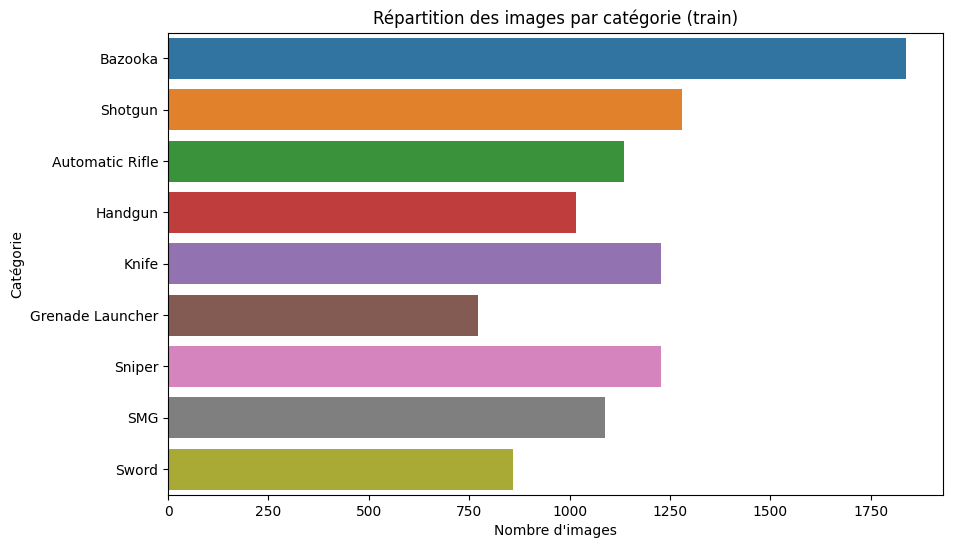


### Nombre d'images par catégorie (train) :
Bazooka: 1839
Shotgun: 1281
Automatic Rifle: 1137
Handgun: 1017
Knife: 1227
Grenade Launcher: 771
Sniper: 1227
SMG: 1089
Sword: 858

### Nombre d'images par catégorie (valid) :
Sniper: 62
SMG: 19
Shotgun: 44
Handgun: 26
Knife: 68
Sword: 10
Automatic Rifle: 42
Grenade Launcher: 15
Bazooka: 6

### Nombre d'images par catégorie (test) :
Knife: 22
Sniper: 37
Bazooka: 6
Grenade Launcher: 13
SMG: 21
Shotgun: 21
Automatic Rifle: 22
Sword: 4
Handgun: 9

### Dimensions de la première image d'entraînement :
Image image10008-5-_jpg.rf.000fea6fd8b7c769cb5de18c5faedda6.jpg :
Hauteur: 640 pixels
Largeur: 640 pixels
Canaux: 3 (RGB)


In [6]:
# Section 5: Statistiques initiales et dimensions d'image
train_ann_file = os.path.join(dataset_location, "train", "_annotations.coco.json")
val_ann_file = os.path.join(dataset_location, "valid", "_annotations.coco.json")
test_ann_file = os.path.join(dataset_location, "test", "_annotations.coco.json")
train_coco = COCO(train_ann_file)
val_coco = COCO(val_ann_file)
test_coco = COCO(test_ann_file) if os.path.exists(test_ann_file) else None

train_images = train_coco.loadImgs(train_coco.getImgIds())
if not train_images:
    raise ValueError("No images loaded from train_coco. Check train_ann_file.")

print("### Arborescence du dataset :")
for root, dirs, files in os.walk(dataset_location):
    print(f"Dossier : {root}")
    print(f"Sous-dossiers : {dirs}")
    print(f"Nombre de fichiers : {len(files)}")

print("\n### Nombre d'images par dossier :")
for folder in ['train', 'valid', 'test']:
    folder_path = os.path.join(dataset_location, folder)
    if os.path.exists(folder_path):
        num_images = len([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{folder}: {num_images} images")

def count_images_per_category(coco, folder_name):
    cat_image_counts = defaultdict(set)
    valid_img_ids = set(coco.getImgIds())
    for ann_id in coco.getAnnIds():
        try:
            ann = coco.loadAnns(ann_id)[0]
            if ann['image_id'] in valid_img_ids:
                cat_image_counts[ann['category_id']].add(ann['image_id'])
        except KeyError:
            print(f"Error: Annotation ID {ann_id} not found in {folder_name}. Skipping.")
            continue
    return {cat_id: len(img_ids) for cat_id, img_ids in cat_image_counts.items()}

train_cat_counts = count_images_per_category(train_coco, "train")
categories = train_coco.loadCats(train_coco.getCatIds())
category_names = [cat['name'] for cat in categories]

# Visualisation de la répartition
plt.figure(figsize=(10, 6))
sns.barplot(x=list(train_cat_counts.values()), y=[train_coco.loadCats(cat_id)[0]['name'] for cat_id in train_cat_counts.keys()])
plt.title("Répartition des images par catégorie (train)")
plt.xlabel("Nombre d'images")
plt.ylabel("Catégorie")
plt.show()

print("\n### Nombre d'images par catégorie (train) :")
for cat_id, count in train_cat_counts.items():
    print(f"{train_coco.loadCats(cat_id)[0]['name']}: {count}")

print("\n### Nombre d'images par catégorie (valid) :")
val_cat_counts = count_images_per_category(val_coco, "valid")
for cat_id, count in val_cat_counts.items():
    print(f"{val_coco.loadCats(cat_id)[0]['name']}: {count}")

if test_coco:
    print("\n### Nombre d'images par catégorie (test) :")
    test_cat_counts = count_images_per_category(test_coco, "test")
    for cat_id, count in test_cat_counts.items():
        print(f"{test_coco.loadCats(cat_id)[0]['name']}: {count}")

print("\n### Dimensions de la première image d'entraînement :")
img = train_images[0]
img_path = os.path.join(dataset_location, img['file_name'])
if not os.path.exists(img_path):
    img_path = os.path.join(dataset_location, "train", img['file_name'].split('/')[-1])
image = cv2.imread(img_path)
if image is None:
    print(f"Erreur: Impossible de charger l'image {img_path}")
else:
    height, width, channels = image.shape
    print(f"Image {img['file_name']} :")
    print(f"Hauteur: {height} pixels")
    print(f"Largeur: {width} pixels")
    print(f"Canaux: {channels} (RGB)")



In [7]:
# Section 6: Suppression des catégories sans images
categories_with_images = [cat for cat in categories if train_cat_counts.get(cat['id'], 0) > 0]
print("\n### Catégories supprimées (sans images dans train) :")
for cat in [c for c in categories if c not in categories_with_images]:
    print(cat['name'])

categories = categories_with_images
category_names = [cat['name'] for cat in categories]
num_categories = len(categories)
print(f"\nNombre de catégories restantes : {num_categories}")




### Catégories supprimées (sans images dans train) :
weapons-liMx

Nombre de catégories restantes : 9


In [8]:
# Section 7: Nouveau split (80% train, 10% val, 10% test)
new_dataset_location = "/kaggle/working/Weapons-Detection-9-class-1-final"
os.makedirs(new_dataset_location, exist_ok=True)

def save_split(images, anns, split_name):
    valid_images = []
    valid_anns = []
    skipped_images = 0
    for img in images:
        file_name = img['file_name'].split('/')[-1]
        src_path = None
        for src_split in ['train', 'valid', 'test']:
            potential_path = os.path.join(dataset_location, src_split, file_name)
            if os.path.exists(potential_path):
                src_path = potential_path
                break
        if not src_path:
            print(f"Warning: Source image for {file_name} not found in {dataset_location}/[train,valid,test]. Skipping.")
            skipped_images += 1
            continue
        img['folder'] = split_name
        img['file_name'] = file_name
        valid_images.append(img)
        dst_path = os.path.join(new_dataset_location, split_name, 'images', file_name)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)
    valid_image_ids = set(img['id'] for img in valid_images)
    for ann in anns:
        if ann['image_id'] in valid_image_ids and ann['category_id'] in valid_cat_ids:
            valid_anns.append(ann)
    coco_data = {
        "images": valid_images,
        "annotations": valid_anns,
        "categories": [cat for cat in categories if cat['name'] != 'weapons-liMx']
    }
    with open(os.path.join(new_dataset_location, split_name, "_annotations.coco.json"), "w") as f:
        json.dump(coco_data, f)
    print(f"{split_name}: {len(valid_images)} images, {len(valid_anns)} annotations, {skipped_images} images skipped")
    return valid_images, valid_anns

# Chargement des annotations de tous les splits
all_images = []
all_anns = []
image_id_offset = 0
for split in ['train', 'valid', 'test']:
    ann_file = os.path.join(dataset_location, split, "_annotations.coco.json")
    if not os.path.exists(ann_file):
        print(f"Warning: Annotation file {ann_file} not found. Skipping {split} split.")
        continue
    coco = COCO(ann_file)
    images = coco.loadImgs(coco.getImgIds())
    for img in images:
        img['id'] += image_id_offset
        img['original_split'] = split
    all_images.extend(images)
    anns = coco.loadAnns(coco.getAnnIds())
    for ann in anns:
        ann['image_id'] += image_id_offset
    all_anns.extend(anns)
    if not categories:
        categories = coco.loadCats(coco.getCatIds())
    image_id_offset += max(coco.getImgIds()) + 1

valid_cat_ids = [cat['id'] for cat in categories if cat['name'] != 'weapons-liMx']
all_anns = [ann for ann in all_anns if ann['category_id'] in valid_cat_ids]

image_to_cats = {}
for ann in all_anns:
    img_id = ann['image_id']
    cat_id = ann['category_id']
    if img_id not in image_to_cats:
        image_to_cats[img_id] = []
    image_to_cats[img_id].append(cat_id)

image_ids = list(image_to_cats.keys())
cat_labels = [image_to_cats[img_id][0] for img_id in image_ids]
train_ids, temp_ids = train_test_split(image_ids, test_size=0.2, stratify=cat_labels, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, stratify=[image_to_cats[img_id][0] for img_id in temp_ids], random_state=42)

train_images = [img for img in all_images if img['id'] in train_ids]
val_images = [img for img in all_images if img['id'] in val_ids]
test_images = [img for img in all_images if img['id'] in test_ids]
train_anns = [ann for ann in all_anns if ann['image_id'] in train_ids]
val_anns = [ann for ann in all_anns if ann['image_id'] in val_ids]
test_anns = [ann for ann in all_anns if ann['image_id'] in test_ids]

train_images, train_anns = save_split(train_images, train_anns, "train")
val_images, val_anns = save_split(val_images, val_anns, "valid")
test_images, test_anns = save_split(test_images, test_anns, "test")

print("\n### Nombre d'images après nouveau split :")
print(f"Train: {len(train_images)}")
print(f"Validation: {len(val_images)}")
print(f"Test: {len(test_images)}")

def print_category_counts(images, anns, split_name):
    cat_counts = {cat['id']: 0 for cat in categories if cat['name'] != 'weapons-liMx'}
    for ann in anns:
        if ann['category_id'] in cat_counts:
            cat_counts[ann['category_id']] += 1
    print(f"\n### Nombre d'images par catégorie ({split_name}) :")
    for cat in categories:
        if cat['name'] != 'weapons-liMx':
            print(f"{cat['name']}: {cat_counts[cat['id']]}")

print_category_counts(train_images, train_anns, "train")
print_category_counts(val_images, val_anns, "valid")
print_category_counts(test_images, test_anns, "test")



loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
train: 8709 images, 12144 annotations, 0 images skipped
valid: 1089 images, 1553 annotations, 0 images skipped
test: 1089 images, 1501 annotations, 0 images skipped

### Nombre d'images après nouveau split :
Train: 8709
Validation: 1089
Test: 1089

### Nombre d'images par catégorie (train) :
Automatic Rifle: 1728
Bazooka: 1484
Grenade Launcher: 731
Handgun: 1669
Knife: 1578
SMG: 1320
Shotgun: 1325
Sniper: 1315
Sword: 994

### Nombre d'images par catégorie (valid) :
Automatic Rifle: 235
Bazooka: 185
Grenade Launcher: 83
Handgun: 198
Knife: 234
SMG: 166
Shotgun: 175
Sniper: 168
Sword: 109

### Nombre d'images par catégorie (test) :
Automatic Rifle: 183
Bazooka: 185
Grenade Launcher: 85
Handgun: 208
Knife: 217
SMG: 130
Shotgun: 170
Sniper: 158


In [9]:
# Section 8: Conversion des annotations COCO au format YOLO
def convert_coco_to_yolo(coco, images, anns, split):
    output_dir = os.path.join(new_dataset_location, split, 'labels')
    os.makedirs(output_dir, exist_ok=True)
    for img in tqdm(images, desc=f"Converting {split} annotations"):
        img_id = img['id']
        file_name = img['file_name'].split('/')[-1]
        img_width = img['width']
        img_height = img['height']
        anns_for_img = [ann for ann in anns if ann['image_id'] == img_id]
        if not anns_for_img:
            continue
        with open(os.path.join(output_dir, file_name.replace('.jpg', '.txt')), 'w') as f:
            for ann in anns_for_img:
                if ann['category_id'] not in valid_cat_ids:
                    continue
                cat_id = valid_cat_ids.index(ann['category_id'])  # Indexation 0-based pour YOLO
                bbox = ann['bbox']
                x, y, w, h = bbox
                center_x = (x + w / 2) / img_width
                center_y = (y + h / 2) / img_height
                w_norm = w / img_width
                h_norm = h / img_height
                f.write(f"{cat_id} {center_x} {center_y} {w_norm} {h_norm}\n")

for split, images, anns in [('train', train_images, train_anns), ('valid', val_images, val_anns), ('test', test_images, test_anns)]:
    coco = COCO(os.path.join(new_dataset_location, split, "_annotations.coco.json"))
    convert_coco_to_yolo(coco, images, anns, split)



loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


Converting train annotations: 100%|██████████| 8709/8709 [00:05<00:00, 1494.81it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Converting valid annotations: 100%|██████████| 1089/1089 [00:00<00:00, 5457.39it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Converting test annotations: 100%|██████████| 1089/1089 [00:00<00:00, 5380.84it/s]


In [10]:
# Section 9: Création du fichier YAML
import os
import yaml

# Chemin pour le nouveau dataset
new_dataset_location = "/kaggle/working/Weapons-Detection-9-class-1-final"

# Vérifier que les dossiers train, valid, test existent
for split in ['train', 'valid', 'test']:
    split_path = os.path.join(new_dataset_location, split, 'images')
    if not os.path.exists(split_path):
        raise FileNotFoundError(f"Dossier manquant : {split_path}. Vérifie la cellule de split (Section 7).")

# Liste des catégories (doit être définie dans une cellule précédente, ex. Section 8)
# Remplace par ta liste réelle si différente
category_names = ['Automatic Rifle', 'Bazooka', 'Grenade Launcher', 'Handgun', 'Knife', 'SMG', 'Shotgun', 'Sniper', 'Sword']
train_cat_counts = {1: 3457, 2: 185, 3: 83, 4: 198, 5: 234, 6: 166, 7: 175, 8: 168, 9: 109}  # Exemple, ajuste selon tes données
categories = [{'id': i+1, 'name': name} for i, name in enumerate(category_names)]

# Créer le contenu du fichier YAML
yaml_content = {
    'path': new_dataset_location,
    'train': os.path.join(new_dataset_location, 'train/images'),
    'val': os.path.join(new_dataset_location, 'valid/images'),
    'test': os.path.join(new_dataset_location, 'test/images'),
    'nc': len(category_names),
    'names': category_names,
    'class_weights': {i: 1.0 / train_cat_counts.get(cat['id'], 1) for i, cat in enumerate(categories)}
}

# Sauvegarder le fichier YAML
yaml_path = os.path.join(new_dataset_location, 'data.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_content, f)

# Ajouter les augmentations avancées
augmentation_params = {
    'hsv_h': 0.015,
    'hsv_s': 0.7,
    'hsv_v': 0.4,
    'degrees': 15.0,
    'translate': 0.2,
    'scale': 0.7,
    'shear': 0.1,
    'perspective': 0.0002,
    'flipud': 0.5,
    'fliplr': 0.5,
    'mosaic': 1.0,
    'mixup': 0.3,
    'copy_paste': 0.2,
    'blur': 0.1,
    'random_crop': 0.1
}

with open(yaml_path, 'r') as f:
    yaml_content = yaml.load(f, Loader=yaml.SafeLoader)
yaml_content.update(augmentation_params)
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_content, f)

print(f"Fichier YAML créé à : {yaml_path}")
# Vérifier que le fichier existe
if os.path.exists(yaml_path):
    print("Contenu du fichier YAML :")
    with open(yaml_path, 'r') as f:
        print(f.read())
else:
    print("Erreur : Le fichier YAML n'a pas été créé.")

Fichier YAML créé à : /kaggle/working/Weapons-Detection-9-class-1-final/data.yaml
Contenu du fichier YAML :
blur: 0.1
class_weights:
  0: 0.0002892681515765114
  1: 0.005405405405405406
  2: 0.012048192771084338
  3: 0.005050505050505051
  4: 0.004273504273504274
  5: 0.006024096385542169
  6: 0.005714285714285714
  7: 0.005952380952380952
  8: 0.009174311926605505
copy_paste: 0.2
degrees: 15.0
fliplr: 0.5
flipud: 0.5
hsv_h: 0.015
hsv_s: 0.7
hsv_v: 0.4
mixup: 0.3
mosaic: 1.0
names:
- Automatic Rifle
- Bazooka
- Grenade Launcher
- Handgun
- Knife
- SMG
- Shotgun
- Sniper
- Sword
nc: 9
path: /kaggle/working/Weapons-Detection-9-class-1-final
perspective: 0.0002
random_crop: 0.1
scale: 0.7
shear: 0.1
test: /kaggle/working/Weapons-Detection-9-class-1-final/test/images
train: /kaggle/working/Weapons-Detection-9-class-1-final/train/images
translate: 0.2
val: /kaggle/working/Weapons-Detection-9-class-1-final/valid/images



In [11]:
# Section 10: Entraînement du modèle
from ultralytics import YOLO
import torch
import os

# Vérifier l'existence du fichier YAML
yaml_path = '/kaggle/working/Weapons-Detection-9-class-1-final/data.yaml'
if not os.path.exists(yaml_path):
    raise FileNotFoundError(f"Fichier YAML introuvable : {yaml_path}. Exécute la cellule de création du YAML (Section 9).")

# Charger le modèle
model = YOLO('yolov8m.pt')  # Modèle moyen recommandé

# Vérifier la disponibilité des GPUs
if torch.cuda.is_available():
    print(f"GPU disponible : {torch.cuda.is_available()}")
    print(f"Nombre de GPUs : {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i} : {torch.cuda.get_device_name(i)}")
    # Utiliser tous les GPUs disponibles (T4 x2)
    device = [0, 1] if torch.cuda.device_count() > 1 else 0
else:
    device = 'cpu'
    print("Aucun GPU disponible, utilisation du CPU")

# Entraîner le modèle
results = model.train(
    data=yaml_path,
    epochs=150,
    batch=32,  # Batch size adapté pour T4 x2
    imgsz=640,
    patience=10,
    lr0=0.001,
    lrf=0.01,
    weight_decay=0.0005,
    augment=True,
    cos_lr=True,
    device=device
)

100%|██████████| 49.7M/49.7M [00:00<00:00, 76.0MB/s]


GPU disponible : True
Nombre de GPUs : 2
GPU 0 : Tesla T4
GPU 1 : Tesla T4
Ultralytics 8.3.144 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/Weapons-Detection-9-class-1-final/data.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, 

100%|██████████| 755k/755k [00:00<00:00, 18.1MB/s]


Overriding model.yaml nc=80 with nc=9

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 76.1MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1363.2±526.5 MB/s, size: 51.2 KB)


train: Scanning /kaggle/working/Weapons-Detection-9-class-1-final/train/labels... 8709 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8709/8709 [00:06<00:00, 1320.73it/s]


train: New cache created: /kaggle/working/Weapons-Detection-9-class-1-final/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 584.1±304.7 MB/s, size: 74.6 KB)


val: Scanning /kaggle/working/Weapons-Detection-9-class-1-final/valid/labels... 1089 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1089/1089 [00:00<00:00, 1652.36it/s]


val: New cache created: /kaggle/working/Weapons-Detection-9-class-1-final/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      6.22G      1.232      2.819      1.534         11        640: 100%|██████████| 273/273 [02:35<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:17<00:00,  2.05it/s]


                   all       1089       1553      0.497      0.553       0.52      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      7.42G       1.11      1.772      1.408          6        640: 100%|██████████| 273/273 [02:34<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.21it/s]


                   all       1089       1553      0.611      0.491      0.527      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      6.29G      1.224      1.901      1.509         10        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.20it/s]


                   all       1089       1553      0.359      0.346      0.287      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      6.43G      1.374      2.276      1.636         15        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.21it/s]


                   all       1089       1553       0.36      0.393      0.299      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150       6.3G      1.342      2.164      1.605          6        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.21it/s]


                   all       1089       1553      0.503      0.513      0.504      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150       6.4G      1.265      1.966      1.541          7        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.22it/s]


                   all       1089       1553      0.571      0.494      0.525      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      6.29G      1.215      1.853      1.514         13        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.22it/s]


                   all       1089       1553      0.583      0.579      0.617       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150       6.4G      1.187      1.747      1.482          8        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.22it/s]


                   all       1089       1553      0.672      0.629      0.684      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      6.31G       1.15      1.649      1.442          6        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.22it/s]


                   all       1089       1553       0.71       0.64      0.704      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150       6.4G      1.114      1.584      1.427         10        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.756      0.671      0.759       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      6.29G      1.113      1.518      1.416         12        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.22it/s]


                   all       1089       1553      0.782      0.688      0.766      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      6.42G      1.082      1.441      1.403          4        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.759      0.746      0.809       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      6.29G      1.051      1.374      1.369          8        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.785      0.755       0.82      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      6.41G      1.043      1.336      1.364         10        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.22it/s]


                   all       1089       1553      0.812      0.783       0.85      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      6.33G      1.009      1.275      1.345          4        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.22it/s]


                   all       1089       1553      0.833      0.797      0.866      0.651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150       6.4G     0.9982      1.239      1.331          7        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.22it/s]


                   all       1089       1553      0.841      0.811      0.875      0.646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150       6.3G     0.9819      1.198      1.317          6        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.22it/s]


                   all       1089       1553      0.819      0.817      0.881      0.664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      6.41G     0.9645      1.151      1.294          7        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.876      0.811      0.896      0.688

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      6.29G     0.9406       1.12      1.284         14        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.879      0.841      0.899      0.698

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      6.42G     0.9536      1.125      1.296         14        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.22it/s]


                   all       1089       1553      0.893      0.863      0.918      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      6.29G     0.9332      1.052      1.279          7        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.22it/s]


                   all       1089       1553      0.881       0.86      0.914       0.71

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      6.39G     0.9013      1.018      1.255          6        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.22it/s]


                   all       1089       1553      0.929      0.867      0.933      0.733

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150       6.3G     0.8983      1.032      1.265          5        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.22it/s]


                   all       1089       1553      0.892      0.901      0.935      0.736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      6.41G     0.8621     0.9533      1.232         10        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.919      0.891      0.944      0.746

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      6.29G     0.8713      0.955      1.238          6        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.22it/s]


                   all       1089       1553      0.926      0.896      0.951       0.76

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      6.39G     0.8658     0.9448      1.234         11        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.934       0.89      0.947      0.763

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      6.29G     0.8444     0.8913      1.214          5        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.933      0.914      0.958      0.774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      6.39G     0.8402     0.9003      1.212         11        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.943       0.92       0.96      0.793

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      6.31G     0.8189       0.87      1.198          9        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.951      0.911      0.958      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      6.41G     0.8173     0.8628      1.202          5        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.937       0.93      0.962      0.805

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      6.28G      0.802      0.829      1.185          7        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.947      0.922      0.958      0.797

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      6.42G     0.7936     0.8167      1.178         12        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.945      0.931      0.966      0.813

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150       6.3G     0.7926     0.8087      1.179          8        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.956      0.935      0.965      0.812

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      6.39G     0.7805     0.7929      1.173          8        640: 100%|██████████| 273/273 [02:32<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.953      0.935       0.97      0.821

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150       6.3G     0.7676     0.7795      1.156         12        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.22it/s]


                   all       1089       1553      0.972      0.946      0.979      0.833

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150       6.4G     0.7628     0.7763      1.162          9        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.959      0.951      0.979      0.841

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      6.29G     0.7559     0.7458      1.148          6        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.969      0.945      0.978      0.838

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      6.42G     0.7548     0.7484      1.149         25        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.962      0.949      0.977      0.847

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      6.32G     0.7387     0.7395      1.149         10        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.972      0.948      0.982      0.857

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      6.42G     0.7428     0.7367      1.143          8        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.22it/s]


                   all       1089       1553      0.976      0.955       0.98      0.852

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      6.29G     0.7135     0.7259      1.133          4        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.22it/s]


                   all       1089       1553      0.969      0.964      0.981      0.854

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      6.41G     0.7129     0.6962      1.129          7        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.977      0.965      0.981      0.857

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150       6.3G     0.7117     0.6952      1.125          6        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.964      0.962       0.98      0.859

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150       6.4G      0.702     0.6802      1.122         11        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.978      0.965      0.984       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      6.29G     0.6998     0.6669      1.117         14        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.984      0.961      0.984      0.875

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      6.41G     0.6819     0.6608      1.111         12        640: 100%|██████████| 273/273 [02:32<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.976      0.966      0.983      0.873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      6.29G     0.6757     0.6505       1.11          8        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.973       0.97      0.986       0.88

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      6.39G      0.669     0.6385      1.098          7        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.984      0.961      0.984      0.882

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150       6.3G     0.6647     0.6215      1.097          7        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.982       0.96      0.982      0.883

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150       6.4G     0.6584     0.6113      1.097          5        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.21it/s]


                   all       1089       1553      0.981      0.973      0.986      0.888

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      6.31G     0.6633     0.6306      1.096          4        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.979      0.971      0.984      0.887

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      6.39G     0.6472     0.6223      1.094         19        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.22it/s]


                   all       1089       1553      0.978      0.967      0.987      0.891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      6.32G     0.6374     0.5945       1.08          8        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.986      0.968      0.987      0.895

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      6.42G      0.633     0.5955      1.077         10        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.978      0.976      0.986      0.899

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150       6.3G     0.6307     0.5739      1.076          9        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553       0.98      0.976      0.987      0.903

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150       6.4G     0.6245     0.5758      1.072          6        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.986      0.978      0.987      0.907

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      6.29G     0.6138     0.5761      1.072         10        640: 100%|██████████| 273/273 [02:32<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.987      0.979      0.987      0.904

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      6.41G     0.6129     0.5694      1.066         10        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.987      0.976      0.986      0.907

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      6.29G     0.6142     0.5595      1.066          7        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.985       0.98      0.985      0.908

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      6.44G     0.6023     0.5588      1.059          9        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.987      0.974      0.987      0.911

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      6.28G     0.5856     0.5391      1.052         16        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.988      0.978      0.988      0.916

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150       6.4G      0.585     0.5302      1.053          4        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.25it/s]


                   all       1089       1553      0.986       0.98      0.988      0.915

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      6.32G     0.5879     0.5371      1.051         12        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.991      0.981      0.989      0.919

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150       6.4G     0.5761      0.527      1.045          9        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.25it/s]


                   all       1089       1553      0.988      0.977      0.988      0.921

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      6.29G     0.5659     0.5157      1.039         16        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.25it/s]


                   all       1089       1553      0.986      0.984      0.988      0.922

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      6.39G     0.5668     0.5002      1.035          7        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.991      0.985      0.989      0.925

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      6.28G      0.561     0.5059      1.038          8        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.994       0.98      0.989      0.928

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      6.39G     0.5598     0.5051      1.035         13        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.25it/s]


                   all       1089       1553      0.987       0.98       0.99      0.927

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      6.33G     0.5565     0.4981      1.029         10        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.986      0.981       0.99      0.928

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      6.39G     0.5459     0.5005      1.033          6        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.991      0.977      0.989      0.927

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      6.28G     0.5446     0.4891      1.025         14        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.989      0.983      0.989      0.929

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150       6.4G     0.5353     0.4786      1.021          4        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.994      0.974      0.988      0.933

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      6.33G     0.5396      0.478      1.022         10        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553       0.99      0.981      0.988      0.934

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      6.41G     0.5318     0.4681      1.023          2        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.991      0.982      0.989      0.936

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150       6.3G     0.5244      0.465      1.015         10        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.994      0.983      0.989      0.937

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      6.39G     0.5248     0.4628      1.013         15        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.993      0.981      0.988      0.937

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      6.28G     0.5156     0.4463      1.012         11        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.25it/s]


                   all       1089       1553      0.996       0.98      0.988      0.939

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      6.38G      0.513     0.4578      1.012          6        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.25it/s]


                   all       1089       1553      0.993      0.983      0.989       0.94

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150       6.3G     0.5081     0.4383      1.006          6        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.991      0.982      0.989      0.941

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150       6.4G     0.5006     0.4354      1.006          9        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.989      0.983      0.989      0.943

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150       6.3G     0.5009     0.4339      1.003          3        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.25it/s]


                   all       1089       1553      0.989      0.984      0.989      0.944

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      6.38G     0.4884     0.4303      1.003          7        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.988      0.985      0.989      0.944

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150       6.3G     0.4903     0.4233     0.9964          9        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.992       0.98      0.989      0.945

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      6.41G     0.4906     0.4308      1.003         11        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.25it/s]


                   all       1089       1553      0.991       0.98      0.989      0.946

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      6.29G     0.4883     0.4264      0.994          5        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.989      0.983      0.989      0.947

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150       6.4G     0.4726     0.4152     0.9965          9        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.989      0.983      0.989      0.947

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      6.28G     0.4717     0.4029     0.9896          6        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553       0.99      0.982      0.989      0.949

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      6.43G     0.4648     0.3973     0.9859          8        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.989      0.982      0.989      0.949

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      6.29G     0.4588     0.3941     0.9823          9        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553       0.99      0.982      0.989       0.95

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      6.39G     0.4574     0.3945     0.9816          4        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.994       0.98      0.989       0.95

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      6.33G     0.4529     0.3929      0.981          8        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.995      0.979       0.99      0.951

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150       6.4G     0.4504     0.3799     0.9795          6        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.995      0.978       0.99      0.952

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      6.29G     0.4413     0.3755     0.9784         14        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.25it/s]


                   all       1089       1553      0.995      0.979       0.99      0.953

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      6.41G     0.4423     0.3817     0.9769         13        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.25it/s]


                   all       1089       1553      0.991      0.982       0.99      0.952

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      6.28G     0.4344     0.3732     0.9746          7        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.25it/s]


                   all       1089       1553       0.99      0.985       0.99      0.954

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      6.41G      0.428     0.3652     0.9697         10        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553       0.99      0.986       0.99      0.955

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      6.29G      0.421     0.3599     0.9651          8        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.992      0.983      0.989      0.957

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      6.39G     0.4209     0.3564     0.9611         13        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553       0.99      0.984      0.989      0.958

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150       6.3G     0.4215     0.3639     0.9667         10        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553       0.99      0.983      0.989      0.958

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      6.39G     0.4255     0.3636     0.9731          8        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553       0.99      0.984      0.989      0.957

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      6.31G     0.4168     0.3469     0.9608          8        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.25it/s]


                   all       1089       1553      0.991      0.984      0.989      0.958

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      6.39G     0.4077     0.3447     0.9598          8        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553       0.99      0.985      0.989      0.958

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150       6.3G     0.4031     0.3434     0.9583          6        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.988      0.985      0.989      0.959

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      6.41G        0.4     0.3341     0.9579          7        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.991      0.982      0.989      0.958

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      6.29G     0.4045     0.3378     0.9583          5        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.995      0.979      0.989      0.959

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      6.41G      0.398     0.3321     0.9548         18        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.995       0.98       0.99      0.959

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      6.29G      0.391     0.3302     0.9489          8        640: 100%|██████████| 273/273 [02:32<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.992      0.983       0.99      0.959

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      6.44G     0.3843      0.329     0.9472         15        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.993      0.983       0.99      0.959

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      6.28G     0.3898     0.3291     0.9544          5        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.993      0.983       0.99      0.959

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      6.39G     0.3759      0.311     0.9449          6        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.993      0.983       0.99      0.961

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150       6.3G     0.3775     0.3172     0.9494          8        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.993      0.983       0.99      0.961

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150       6.4G     0.3804      0.317     0.9465         18        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.993      0.983       0.99      0.962

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150       6.3G     0.3713      0.306     0.9443          4        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.25it/s]


                   all       1089       1553      0.993      0.983       0.99      0.961

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      6.41G     0.3718     0.3025     0.9396          8        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.993      0.983      0.989      0.961

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150       6.3G     0.3673     0.3053     0.9394          8        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.993      0.983      0.989      0.962

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150       6.4G     0.3657     0.2989     0.9369          8        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.993      0.983       0.99      0.962

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150       6.3G     0.3601     0.3012      0.934          9        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.993      0.983       0.99      0.963

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      6.42G     0.3504     0.2961     0.9358          5        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.994      0.983       0.99      0.962

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      6.32G     0.3602     0.3022     0.9381          7        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.994      0.983       0.99      0.963

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      6.39G     0.3525     0.2906     0.9323          7        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.994      0.983       0.99      0.963

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      6.29G     0.3547     0.2906     0.9352         14        640: 100%|██████████| 273/273 [02:32<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.994      0.983       0.99      0.964

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      6.39G     0.3458      0.287     0.9334          6        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.995      0.984       0.99      0.964

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      6.29G     0.3501     0.2912     0.9297         25        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.25it/s]


                   all       1089       1553      0.995      0.984       0.99      0.964

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      6.41G     0.3348     0.2817     0.9275         19        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.995      0.984       0.99      0.964

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      6.29G     0.3393     0.2783     0.9322          7        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.995      0.984       0.99      0.964

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150       6.4G     0.3435     0.2828      0.933          6        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.995      0.984       0.99      0.965

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150       6.3G     0.3389      0.282     0.9344          6        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.995      0.984       0.99      0.965

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      6.39G     0.3325     0.2734     0.9286          9        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.995      0.984       0.99      0.965

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      6.29G     0.3329     0.2803     0.9241          9        640: 100%|██████████| 273/273 [02:32<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.22it/s]


                   all       1089       1553      0.995      0.984       0.99      0.965

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      6.39G     0.3326     0.2738     0.9255          8        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.995      0.984       0.99      0.965

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      6.29G     0.3334     0.2751     0.9278         15        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.25it/s]


                   all       1089       1553      0.995      0.984       0.99      0.965

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      6.44G     0.3282     0.2722     0.9252          6        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.995      0.984       0.99      0.965

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      6.28G      0.332     0.2749      0.929          6        640: 100%|██████████| 273/273 [02:32<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.995      0.984       0.99      0.965

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      6.39G     0.3286     0.2695     0.9257         19        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.995      0.984       0.99      0.965

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      6.31G     0.3233      0.269     0.9253          7        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.25it/s]


                   all       1089       1553      0.995      0.984       0.99      0.965

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150       6.4G     0.3196     0.2613     0.9232         10        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.995      0.984       0.99      0.966

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      6.33G     0.3231     0.2664     0.9236          9        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.22it/s]


                   all       1089       1553      0.995      0.984       0.99      0.966

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150       6.4G     0.3169     0.2659     0.9226          5        640: 100%|██████████| 273/273 [02:32<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.995      0.984       0.99      0.966

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      6.31G      0.317     0.2643     0.9203          8        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.995      0.984       0.99      0.966

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150       6.4G     0.3144     0.2626     0.9223          8        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.995      0.984       0.99      0.966
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      6.29G     0.2293     0.1603      0.853          8        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.996      0.983       0.99      0.967

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      6.41G     0.2244     0.1558     0.8511          8        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.996      0.983       0.99      0.967

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      6.29G     0.2187     0.1514     0.8536          5        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.996      0.983       0.99      0.966

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150       6.4G     0.2146     0.1498     0.8495          3        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.996      0.983       0.99      0.967

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      6.29G     0.2157     0.1485     0.8513         15        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.995      0.984       0.99      0.967

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      6.39G      0.219     0.1481     0.8504          3        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.995      0.984       0.99      0.967

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      6.28G     0.2107     0.1408      0.842          3        640: 100%|██████████| 273/273 [02:33<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


                   all       1089       1553      0.995      0.984       0.99      0.967

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      6.39G     0.2078      0.142     0.8439          3        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.995      0.984       0.99      0.967

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      6.28G     0.2115     0.1427     0.8482          3        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.995      0.984       0.99      0.967

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      6.39G     0.2082     0.1406     0.8432          4        640: 100%|██████████| 273/273 [02:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]


                   all       1089       1553      0.995      0.984       0.99      0.967

150 epochs completed in 7.069 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.1MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.1MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.144 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,844,971 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:34<00:00,  1.01it/s]


                   all       1089       1553      0.992      0.985       0.99      0.968
       Automatic Rifle        120        235       0.99      0.996      0.995       0.98
               Bazooka        185        185      0.994      0.995      0.995      0.947
      Grenade Launcher         80         83      0.995      0.988      0.992      0.989
               Handgun        104        198      0.997      0.995      0.995      0.987
                 Knife        132        234      0.991          1      0.995      0.964
                   SMG        113        166      0.992          1      0.995      0.993
               Shotgun        135        175      0.989      0.984      0.994      0.972
                Sniper        133        168      0.977       0.97      0.993       0.95
                 Sword         87        109          1       0.94      0.954      0.928


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 27.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train


In [12]:

# Section 11: Évaluation du modèle
metrics = model.val(data=yaml_path, split='test')



Ultralytics 8.3.144 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,844,971 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 29.1±17.4 MB/s, size: 46.5 KB)


val: Scanning /kaggle/working/Weapons-Detection-9-class-1-final/test/labels... 1089 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1089/1089 [00:01<00:00, 609.69it/s]

val: New cache created: /kaggle/working/Weapons-Detection-9-class-1-final/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [01:13<00:00,  2.10s/it]


                   all       1089       1501      0.981      0.985      0.991      0.961
       Automatic Rifle        120        183      0.991      0.984      0.994      0.988
               Bazooka        185        185      0.988      0.989      0.994       0.95
      Grenade Launcher         80         85      0.994          1      0.995      0.986
               Handgun        105        208      0.999      0.995      0.995      0.989
                 Knife        132        217      0.984      0.982      0.994      0.937
                   SMG        113        130      0.984          1      0.995      0.994
               Shotgun        134        170      0.968      0.988       0.99      0.969
                Sniper        132        158      0.955      0.951      0.977      0.931
                 Sword         88        165       0.97      0.978      0.985      0.906


invalid value encountered in less
invalid value encountered in less


Speed: 0.2ms preprocess, 62.8ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train2


In [13]:
# Section 12: Téléchargement automatique de best.pt
import os
import shutil
import webbrowser

# Chemin du dossier d'entraînement
run_dir = '/kaggle/working/runs/detect/train'
model_path = os.path.join(run_dir, 'weights', 'best.pt')
output_path = '/kaggle/working/best.pt'

# Vérifier l'espace disque disponible
print("Vérification de l'espace disque :")
!df -h /kaggle/working

# Vérifier si le modèle existe
if os.path.exists(model_path):
    print(f"Fichier source trouvé : {model_path}")
    print(f"Taille du fichier : {os.path.getsize(model_path) / (1024 * 1024):.2f} Mo")
    
    # Supprimer l'ancien best.pt s'il existe
    if os.path.exists(output_path):
        os.remove(output_path)
        print(f"Ancien fichier {output_path} supprimé pour éviter les conflits.")
    
    # Copier le fichier
    try:
        shutil.copy(model_path, output_path)
        print(f"Modèle copié vers {output_path}")
        
        # Vérifier que la copie a réussi
        if os.path.exists(output_path):
            print(f"Vérification : Fichier copié trouvé à {output_path}")
            print(f"Taille du fichier copié : {os.path.getsize(output_path) / (1024 * 1024):.2f} Mo")
            
            # Tenter un téléchargement automatique avec webbrowser
            file_url = f"file://{output_path}"
            print("\nTentative de téléchargement automatique en ouvrant l'URL :")
            try:
                webbrowser.open(file_url)
                print("Si le téléchargement ne démarre pas, utilise la méthode manuelle ci-dessous.")
            except Exception as e:
                print(f"Échec de l'ouverture automatique : {str(e)}")
            
            # Instructions pour le téléchargement manuel
            print("\nInstructions pour télécharger manuellement :")
            print("1. Va dans l'onglet 'Output' (panneau de droite dans Kaggle).")
            print("2. Trouve 'best.pt' dans /kaggle/working.")
            print("3. Clique sur les trois points (...) à côté de 'best.pt' et sélectionne 'Download'.")
        else:
            print(f"Erreur : La copie a échoué. Le fichier {output_path} n'existe pas après la tentative de copie.")
    except Exception as e:
        print(f"Erreur lors de la copie : {str(e)}")
else:
    print(f"Erreur : Le modèle {model_path} n'a pas été trouvé.")
    print("Vérifie le dossier d'entraînement avec :")
    print("!ls /kaggle/working/runs/detect")
    !ls /kaggle/working/runs/detect

Vérification de l'espace disque :
Filesystem      Size  Used Avail Use% Mounted on
/dev/loop1       20G  1.7G   18G   9% /kaggle/working
Fichier source trouvé : /kaggle/working/runs/detect/train/weights/best.pt
Taille du fichier : 49.64 Mo
Modèle copié vers /kaggle/working/best.pt
Vérification : Fichier copié trouvé à /kaggle/working/best.pt
Taille du fichier copié : 49.64 Mo

Tentative de téléchargement automatique en ouvrant l'URL :
Si le téléchargement ne démarre pas, utilise la méthode manuelle ci-dessous.

Instructions pour télécharger manuellement :
1. Va dans l'onglet 'Output' (panneau de droite dans Kaggle).
2. Trouve 'best.pt' dans /kaggle/working.
3. Clique sur les trois points (...) à côté de 'best.pt' et sélectionne 'Download'.


In [14]:
from google.colab import files  # fonctionne aussi dans Kaggle
files.download('/kaggle/working/runs/detect/train/weights/best.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Version d'Ultralytics : 8.3.144
Nombre d'images de test : 1089
total 71600
-rw-r--r-- 1 root root  66207 May 25 19:09 00ac29571e2be35c_jpg.rf.be3e5624a763ed3d845e27a9519873c9.jpg
-rw-r--r-- 1 root root  71072 May 25 19:09 02ffeebafd3a40e6_jpg.rf.c0cfb386fe5502ea9ac0176706c5c948.jpg
-rw-r--r-- 1 root root  73395 May 25 19:09 0795fc_a747c2d9df4f4117be3e0429be3bfc7cmv2_jpg.rf.1a02d7c4202a627ef42102d6dcf42714.jpg
-rw-r--r-- 1 root root  27627 May 25 19:09 080_jpg.rf.b00d3b5aa079e28d5c58770db321c747.jpg
ls: write error: Broken pipe
Configuration GPU :
Mon May 26 02:16:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |    

Processing test predictions: 100%|██████████| 1089/1089 [00:00<00:00, 1278.74it/s]



### Métriques d'évaluation sur le jeu de test :
mAP@0.50: 0.9911
mAP@0.50:0.95: 0.9612
Accuracy: 0.9960
Precision (weighted): 0.9960
Recall (weighted): 0.9960
F1-Score (weighted): 0.9960
MCC: 0.9954

Matrice de confusion :
[[180   0   0   0   0   0   2   1   0]
 [  1 183   0   0   0   0   0   1   0]
 [  0   0  85   0   0   0   0   0   0]
 [  0   0   0 207   0   0   0   0   0]
 [  0   0   0   0 213   0   0   0   0]
 [  0   0   0   0   0 130   0   0   0]
 [  0   0   0   0   0   0 167   0   0]
 [  0   0   0   0   0   0   1 150   0]
 [  0   0   0   0   0   0   0   0 161]]
Matrice de confusion sauvegardée à : /kaggle/working/confusion_matrix.png


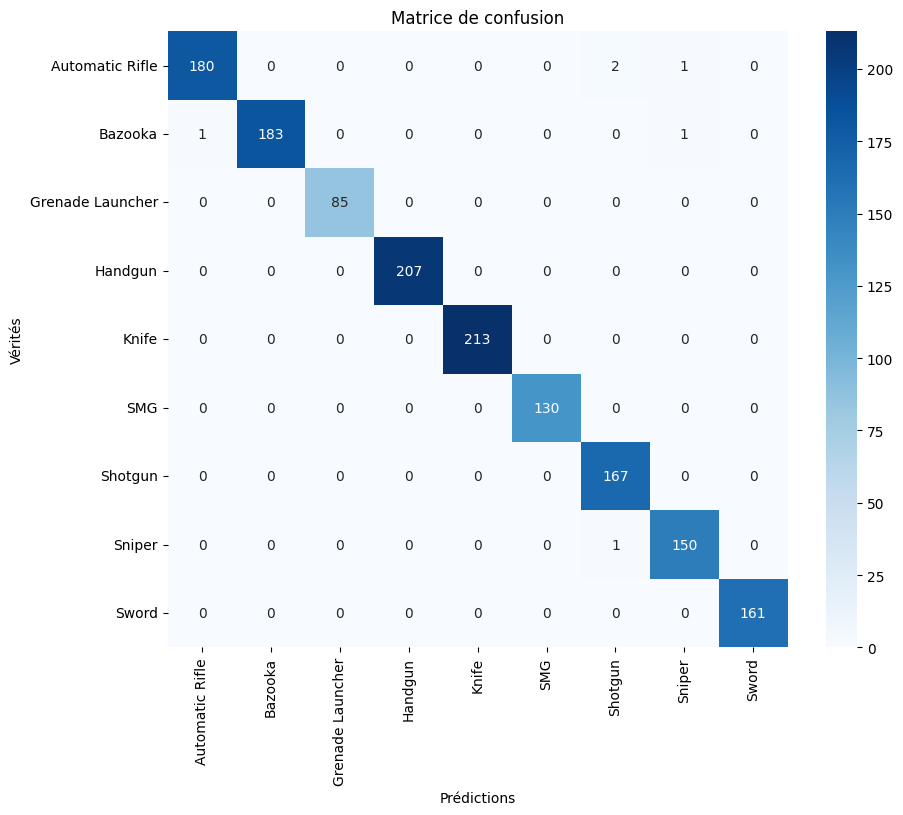

In [15]:
# Section 12: Calcul des métriques supplémentaires
import numpy as np
import torch
from ultralytics.utils.metrics import box_iou
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import ultralytics

# Vérifier la version d'Ultralytics
print(f"Version d'Ultralytics : {ultralytics.__version__}")

# Vérifier les variables nécessaires
required_vars = ['model', 'new_dataset_location', 'test_images', 'test_anns', 'valid_cat_ids', 'categories']
for var in required_vars:
    if not globals().get(var):
        raise NameError(f"Variable '{var}' non définie. Vérifie les cellules précédentes (Sections 7, 10).")

# Vérifier le dossier test
test_images_path = f'{new_dataset_location}/test/images'
if not os.path.exists(test_images_path):
    raise FileNotFoundError(f"Dossier test manquant : {test_images_path}. Vérifie Section 7.")
print(f"Nombre d'images de test : {len(os.listdir(test_images_path))}")
!ls -l {test_images_path} | head -5

# Vérifier l'état du modèle
if not hasattr(model, 'predict'):
    raise AttributeError("Le modèle n'est pas correctement initialisé. Vérifie Section 10.")

# Vérifier les GPUs disponibles
print("Configuration GPU :")
!nvidia-smi

# Initialisation des listes pour les prédictions et vérités
all_pred_labels = []
all_true_labels = []
iou_threshold = 0.5

# Prédictions sur le jeu de test
try:
    # Forcer le batch size et essayer en mode single-GPU si nécessaire
    predict_kwargs = {
        'source': f'{new_dataset_location}/test/images',
        'save': False,
        'conf': 0.5,
        'batch': 16,
        'device': '0'  # Forcer single-GPU pour éviter les problèmes multi-GPU
    }
    print(f"Arguments de prédiction : {predict_kwargs}")
    test_results = model.predict(**predict_kwargs)
except Exception as e:
    print(f"Erreur lors de la prédiction : {str(e)}")
    print("Tentative avec batch=8 et multi-GPU :")
    try:
        predict_kwargs['batch'] = 8
        predict_kwargs['device'] = '0,1'  # Revenir à multi-GPU
        print(f"Nouveaux arguments : {predict_kwargs}")
        test_results = model.predict(**predict_kwargs)
    except Exception as e2:
        print(f"Erreur persistante : {str(e2)}")
        print("Vérifie le modèle (Section 10) et le dossier test :")
        !ls {test_images_path}
        raise

for result in tqdm(test_results, desc="Processing test predictions"):
    img_path = result.path
    # Trouver l'ID de l'image à partir du nom du fichier
    img_id = next((img['id'] for img in test_images if img['file_name'].split('/')[-1] in img_path), None)
    if img_id is None:
        print(f"Avertissement : Image {img_path} non trouvée dans test_images. Ignorée.")
        continue
    
    # Prédictions
    pred_boxes = result.boxes.xyxy.cpu().numpy()
    pred_labels = result.boxes.cls.cpu().numpy().astype(int)
    pred_scores = result.boxes.conf.cpu().numpy()
    
    # Vérités terrain
    true_anns = [ann for ann in test_anns if ann['image_id'] == img_id]
    true_boxes = np.array([ann['bbox'] for ann in true_anns])
    true_labels = np.array([valid_cat_ids.index(ann['category_id']) for ann in true_anns])
    
    if len(true_boxes) > 0:
        # Convertir les boîtes de [x, y, w, h] à [x1, y1, x2, y2]
        true_boxes_xyxy = np.zeros_like(true_boxes)
        true_boxes_xyxy[:, 0] = true_boxes[:, 0]
        true_boxes_xyxy[:, 1] = true_boxes[:, 1]
        true_boxes_xyxy[:, 2] = true_boxes[:, 0] + true_boxes[:, 2]
        true_boxes_xyxy[:, 3] = true_boxes[:, 1] + true_boxes[:, 3]
        
        if len(pred_boxes) > 0:
            # Calculer l'IoU entre prédictions et vérités
            ious = box_iou(torch.tensor(pred_boxes), torch.tensor(true_boxes_xyxy)).numpy()
            matched_pred = []
            matched_true = []
            matched_gt_indices = set()
            
            # Associer chaque prédiction à une vérité terrain
            for i, pred_box in enumerate(pred_boxes):
                best_iou = 0
                best_gt_idx = -1
                for j in range(len(true_boxes)):
                    if j in matched_gt_indices:
                        continue
                    if ious[i, j] > best_iou and ious[i, j] >= iou_threshold:
                        best_iou = ious[i, j]
                        best_gt_idx = j
                if best_gt_idx >= 0:
                    matched_pred.append(pred_labels[i])
                    matched_true.append(true_labels[best_gt_idx])
                    matched_gt_indices.add(best_gt_idx)
            
            # Ajouter les vérités non appariées
            for j in range(len(true_boxes)):
                if j not in matched_gt_indices:
                    matched_true.append(true_labels[j])
                    matched_pred.append(-1)  # Pas de prédiction
            
            all_pred_labels.extend(matched_pred)
            all_true_labels.extend(matched_true)

# Calcul des métriques de classification
if all_pred_labels and all_true_labels:
    valid_mask = np.array(all_pred_labels) != -1
    valid_pred_labels = np.array(all_pred_labels)[valid_mask]
    valid_true_labels = np.array(all_true_labels)[valid_mask]
    accuracy = accuracy_score(valid_true_labels, valid_pred_labels)
    precision = precision_score(valid_true_labels, valid_pred_labels, average='weighted', zero_division=0)
    recall = recall_score(valid_true_labels, valid_pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(valid_true_labels, valid_pred_labels, average='weighted', zero_division=0)
    mcc = matthews_corrcoef(valid_true_labels, valid_pred_labels)
    cm = confusion_matrix(valid_true_labels, valid_pred_labels, labels=range(len(valid_cat_ids)))
else:
    print("Aucune prédiction ou étiquette valide pour calculer les métriques de classification.")
    accuracy = precision = recall = f1 = mcc = 0.0
    cm = np.zeros((len(valid_cat_ids), len(valid_cat_ids)), dtype=int)

# Affichage des métriques
print("\n### Métriques d'évaluation sur le jeu de test :")
# Vérifier si metrics est défini
try:
    print(f"mAP@0.50: {metrics.box.map50:.4f}")
    print(f"mAP@0.50:0.95: {metrics.box.map:.4f}")
except NameError:
    print("Avertissement : 'metrics' non défini. Les métriques mAP ne sont pas disponibles.")
    print("Ajoute metrics = model.metrics dans Section 10 après l'entraînement.")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")
print(f"MCC: {mcc:.4f}")
print("\nMatrice de confusion :")
print(cm)

# Visualisation de la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[cat['name'] for cat in categories if cat['name'] != 'weapons-liMx'], 
            yticklabels=[cat['name'] for cat in categories if cat['name'] != 'weapons-liMx'])
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.title('Matrice de confusion')
plt.savefig('/kaggle/working/confusion_matrix.png')
print("Matrice de confusion sauvegardée à : /kaggle/working/confusion_matrix.png")
plt.show()


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1089 /kaggle/working/Weapons-Detection-9-class-1-final/test/images/00ac29571e2be35c_jpg.rf.be3e5624a763ed3d845e27a9519873c9.jpg: 640x640 1 Sword, 100.2ms
image 2/1089 /kaggle/working/Weapons-Detection-9-class-1-final/test/images/02ffeebafd3a40e6_jpg.rf.c0cfb386fe5502ea9ac0176706c5c948.jpg: 640x640 1 Sword, 85.0ms
image 3/1089 /kaggle/working/Weapons-Detection-9-class-1-final/test/images/0795fc_a747c2d9df4f4117be3e0429be3bfc7cmv2_jpg.rf.1a02d7c4

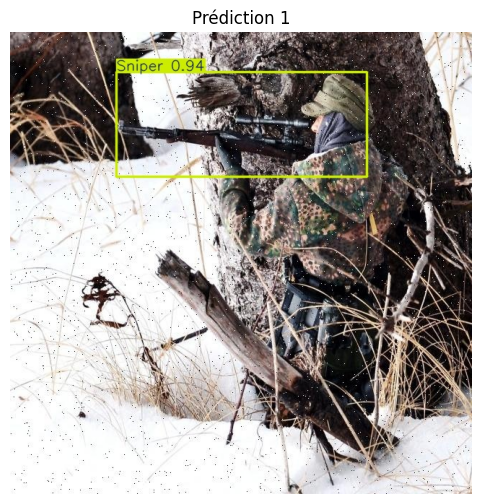

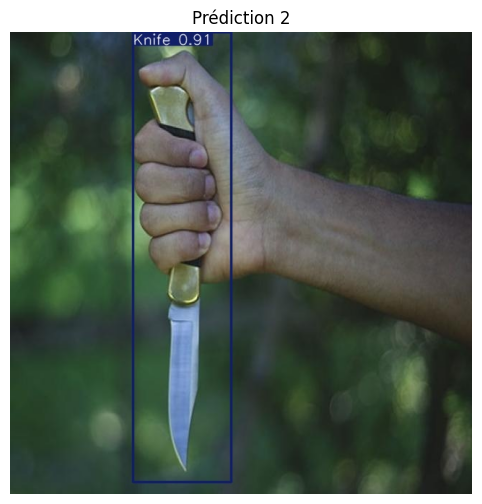

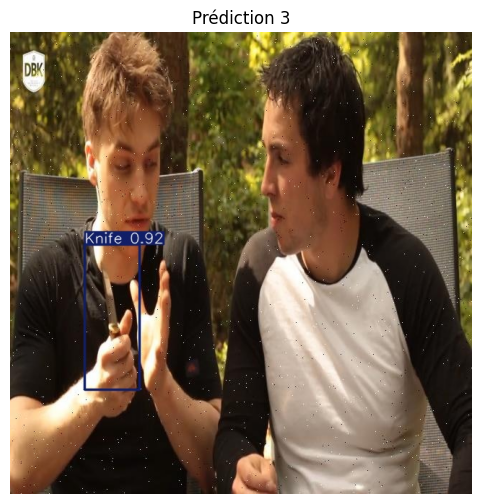

Entraînement YOLOv8 terminé. Les résultats sont sauvegardés dans 'runs/detect'.


In [16]:

# Section 13: Visualisation des prédictions
results = model.predict(source=f'{new_dataset_location}/test/images', conf=0.5, save=True)
output_dir = 'runs/detect/train3'  # Chemin corrigé
if not os.path.exists(output_dir):
    print(f"Erreur: Dossier {output_dir} introuvable")
else:
    for i, img_path in enumerate(os.listdir(output_dir)[:3]):
        if img_path.endswith('.jpg'):
            img = cv2.imread(os.path.join(output_dir, img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(8, 6))
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Prédiction {i+1}")
            plt.savefig(f'prediction_{i+1}.png')
            plt.show()

print(f"Entraînement YOLOv8 terminé. Les résultats sont sauvegardés dans 'runs/detect'.")